# Analysis of Cell-free and HIV - Figure 1

This notebook will present analyses and discussions of the GH-VAP project looking for potential microbiome causes/associations with individuals who produce broadly neutralizing antibodies to HIV; as well as everything else I can learn from the transcriptome. 

This specific notebook will handle the code to generate figure 1.

## Authors: 
 - 1. Mark Kowarsky 
 - **Date Updated:** 2018-10-24

 - 2. Yike Xie
 - **Date Updated:** 2025-05



#### Code cleaned by:
- Mercedes Dalman
- **Date Updated:** 2025-09

## Imports and stylings

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from collections import defaultdict
import os
from matplotlib import rcParams
import re
from Bio import Phylo


#from wordcloud import WordCloud
from matplotlib.colors import to_hex

from ete3 import NCBITaxa#,# TreeStyle, NodeStyle, faces

from IPython.core.pylabtools import figsize

from scipy.interpolate import PchipInterpolator
from scipy.stats.mstats import spearmanr

from sklearn import decomposition, manifold

from adjustText import adjust_text

#%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'sklearn'

In [3]:
# Colours from Material Design - https://material.io/tools/color/
green = "#388e3c"
light_green = "#6abf69"
dark_green = "#00600f"

blue = "#1976d2"
light_blue = "#63a4ff"
dark_blue = "#004ba0"

red = "#d32f2f"
light_red = "#ff6659"
dark_red = "#9a0007"

yellow = "#fbc02d"
light_yellow = "#fff263"
dark_yellow = "#c49000"

grey = "#616161"
light_grey = "#8e8e8e"
dark_grey = "#373737"

orange = "#f57c00"
light_orange = "#ffad42"
dark_orange = "#bb4d00"

purple = "#7b1fa2"
dark_purple = "#4a0072"
light_purple = "#ae52d4"

# Load Data

In [4]:
# Load breadth metadata
breadth_metadata = pd.read_excel("tables/Gates_metadata.xlsx", index_col=[22, 23])
breadth_metadata.index = ["_".join(map(str,x)) for x in breadth_metadata.index]
breadth_metadata["Patient"] = [x.split("_")[0] for x in breadth_metadata.index]
breadth_metadata["sample"] = "SAMPLE_" + breadth_metadata["Patient"] + "_" + breadth_metadata["Years PI"].astype(str)
breadth_metadata.set_index("sample", inplace=True)

In [5]:
def convert_less_than(x):
    if isinstance(x, str) and "<" in x:
        return 0
    else:
        return float(x)

In [6]:
# Load design matrix
design = pd.read_table("tables/edgeR_design.txt", index_col=0)

a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [7]:
meta1 = pd.read_excel("tables/Gates_metadata.xlsx", sheet_name=1)
meta1["sample"] = "SAMPLE_" + meta1["PID"].astype(str) + 14*["_1", "_2", "_3"]
meta1.set_index("sample", inplace=True)

# Panel A

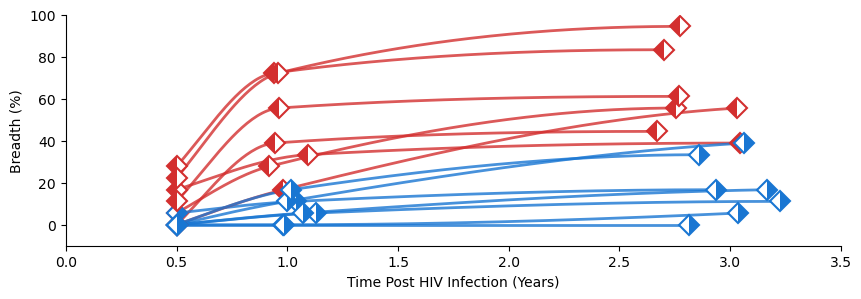

In [8]:
# In years from infection
figsize(10, 3)
for p, df in breadth_metadata.groupby("Patient"):
    if design.loc[df.index[0], "bNAbs"] == "Y":
        color, fillstyle = red, "left"
    else:
        color, fillstyle = blue, "right"

    # dates for this patient's visits
    t_dates = pd.to_datetime(meta1.loc[df.index, "vdate"])
    inf_date = t_dates.min()

    # x-axis in YEARS since infection 
    x_years = (t_dates - inf_date).dt.days / 365.25 + 0.5
    y = 100 * df["% breadth"].fillna(0).values


    X = np.linspace(x_years.min(), x_years.max(), 200)
    Y = PchipInterpolator(x_years.values, y)(X)

    plt.plot(x_years, y,
             marker="D", markersize=10, color=color, linewidth=0,
             markerfacecoloralt="white", fillstyle=fillstyle, markeredgewidth=0)
    plt.plot(x_years, y,
             marker="D", markersize=10, color=color, linewidth=0,
             markerfacecoloralt="white", fillstyle="none", markeredgewidth=1.5)
    plt.plot(X, Y, linewidth=2, zorder=0, alpha=0.8, color=color)

plt.xlabel("Time Post HIV Infection (Years)")
plt.ylabel("Breadth (%)")

plt.xlim(0,3.5)
plt.ylim(-10,100)

sns.despine()
plt.savefig("figures/figure1/panel_A/s1_time_series_years.svg")
plt.show()


# Panel B - Cluster Map

/tmp/ipykernel_147078/1246304700.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  g = sns.clustermap(np.log10((breadth_metadata.iloc[:, 2:-3].loc[c].applymap(convert_less_than))+1).fillna(0), cmap="inferno",


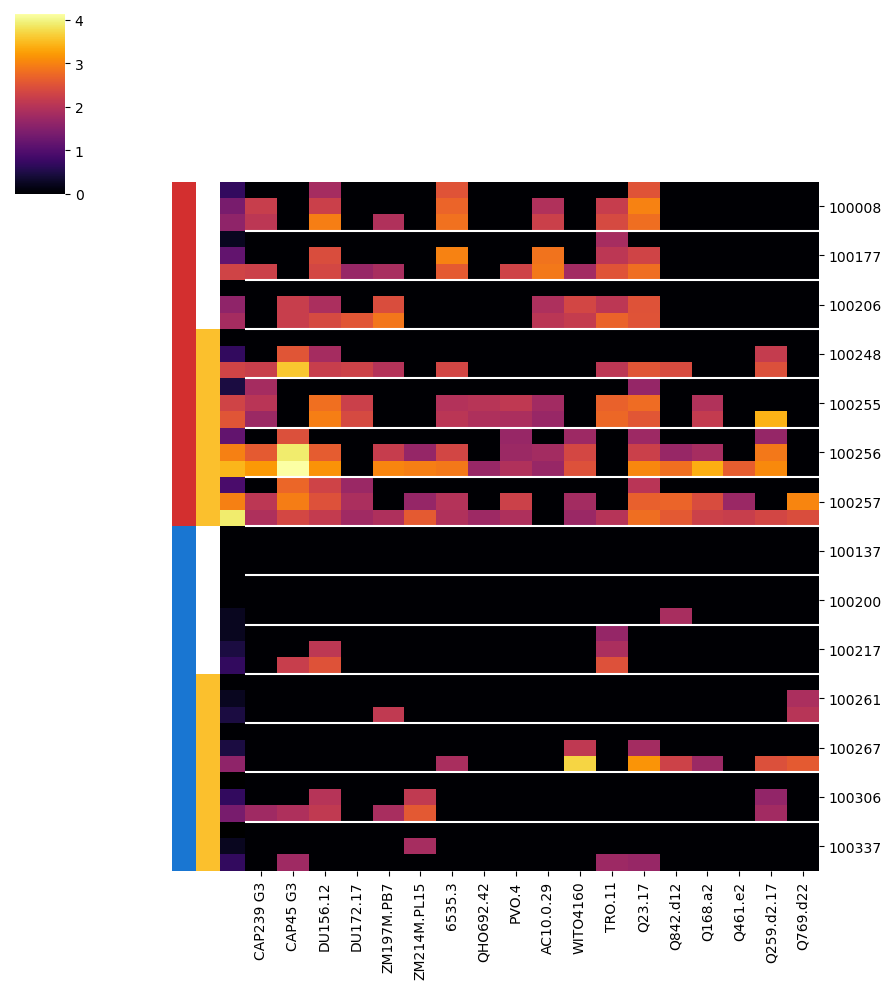

In [9]:
g = sns.clustermap(np.log10((breadth_metadata.iloc[:, 2:-3].loc[c].applymap(convert_less_than))+1).fillna(0), cmap="inferno",
              row_cluster=False, col_cluster=False, figsize=(10, 10), yticklabels=3,
              row_colors=[
            [red if i == "Y" else blue for i in [design.loc[i, "bNAbs"] for i in c]],
            ["white" if i == "E" else yellow for i in [design.loc[i, "Location"] for i in c]],
            breadth_metadata.loc[c]["% breadth"].apply(lambda x: plt.cm.inferno(x))])

g.ax_heatmap.set_yticks([i*3+1.5 for i in range(14)])
g.ax_heatmap.set_yticklabels(breadth_metadata.loc[c]["Patient"].unique())
g.ax_heatmap.set_ylabel('')

for i in range(1,14):
    g.ax_heatmap.axhline(i*3, color='white')

os.makedirs('figures/figure1/panel_B', exist_ok = True)
g.savefig("figures/figure1/panel_B/breadth_assay.svg")

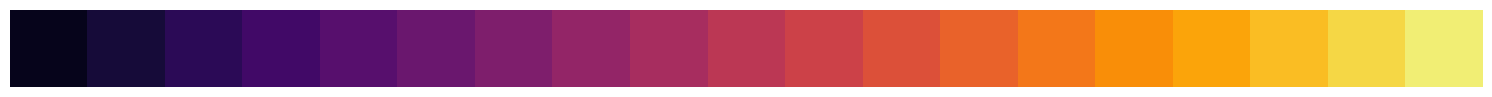

In [10]:
sns.palplot(sns.color_palette("inferno", n_colors=19))
plt.axis('off')
plt.savefig("figures/figure1/panel_B/breadth_palette.svg")